In [279]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import torch,cv2
import numpy as np
import copy
import torchxrayvision as xrv
import torch.nn.functional as F

from typing import Tuple 
from functools import partial
from matplotlib import pyplot as plt
from univdt.components import NIH
from pytorch_grad_cam import GradCAM
from univdt.components.nih import MAPPER    
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

root_dir = 'C:\\nih\\nih' # TODO: set root dir
nih = partial(NIH, root_dir=root_dir, transform=None)

nih_val = nih(split='val')
print(len(nih_val))
assert len(nih_val) == 9925

data = nih_val.load_data(0)
image = data['image']
label = data['label']
image = np.expand_dims(image, axis=0)  # image의 차원을 확장
image = np.expand_dims(image, axis=1)  # image의 차원을 확장
image = np.squeeze(image)   # image의 공간 차원 수를 2차원으로 변경
print(image.shape, label) 
print("Image shape:", image.shape)

model = xrv.models.ResNet(weights="resnet50-res512-all")

cam = GradCAM(model=model, target_layers=model.model.layer4)

# 새로운 배열 정의
new_pathologies = {'normal': 0, 'Atelectasis': 3, 'Consolidation': 5, 'Infiltration': 13, 'Pneumothorax': 10, 
                   'Edema': 4, 'Emphysema': 2, 'Fibrosis': 12, 'Effusion': 1, 'Pneumonia': 11, 
                   'Pleural_Thickening': 6, 'Nodule': 9, 'Mass': 8, 'Hernia': 7}

# 이미지의 형태 변환
image_tensor = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)

# 새로운 인덱스 생성
new_idx_mapping = {}
for pathology, idx in new_pathologies.items():
    if pathology in MAPPER:
        new_idx_mapping[pathology] = MAPPER[pathology]
    else:
        new_idx_mapping[pathology] = idx

def min_max_norm(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

def post_process_cam(prob, actmap: np.ndarray, image: np.ndarray, threshold: float = 0.5, color_contour=(255, 0, 255)) -> Tuple[np.ndarray, np.ndarray]:
    if prob < threshold:
        draw = copy.deepcopy(image)
        mask = np.zeros_like(image)
        return draw, mask

    actmap = min_max_norm(actmap)
    new_cam = copy.deepcopy(actmap)

    # 가우시안 블러 적용
    new_cam = cv2.GaussianBlur(new_cam, (5, 5), 0)

    # for calc contours
    new_cam2 = np.where(new_cam > threshold, 1, 0).astype(np.uint8)
    contours, _ = cv2.findContours(new_cam2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    new_cam = np.where(new_cam > threshold, new_cam, 0)

    filtered_contours = []
    for contour in contours:
        # 컨투어 내부의 최대 값 찾기
        max_value = np.max(new_cam * (cv2.drawContours(np.zeros_like(new_cam), [contour], 0, 1, thickness=cv2.FILLED)))
        # 최대 값이 0.8 이상인 경우만 남기기
        if max_value >= 0.8:
            filtered_contours.append(contour)

    # 이미지가 그레이스케일이 아닌 경우에만 RGB로 변환
    if image.shape[-1] != 3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # 원본에 컨투어 그리기
    draw = cv2.drawContours(copy.deepcopy(image), filtered_contours, -1, color_contour, 1)
    mask = np.zeros_like(image)

    # 컨투어 내부를 히트맵으로 채우기
    heatmap = cv2.applyColorMap((new_cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
    mask = cv2.drawContours(mask, filtered_contours, -1, (255, 255, 255), -1)
    mask = cv2.bitwise_and(heatmap, mask)
    print("Shape of mask:", mask.shape)
    print("Shape of heatmap:", heatmap.shape)

    return draw, mask

# 이미지에 대한 연산을 수행하고 결과를 출력하는 함수
def process_and_show_result(new_idx):
    print("Current new_idx:", new_idx)

    # 튜플 형식인 경우 처리
    if isinstance(new_idx, tuple):
        new_idx = new_idx[0]

    # new_idx에 해당하는 병변 찾기
    pathology = None
    for key, value in new_pathologies.items():
        if new_idx == value:
            pathology = key
            break

    if pathology is None:
        print("No pathology found for new_idx:", new_idx)
        return

    print("Pathology from new_pathologies:", pathology)

    # 이미지를 텐서로 변환하여 리사이징
    image_tensor = torch.from_numpy(image).float().unsqueeze(0).unsqueeze(0)

    # GradCAM 실행
    actmap = cam(input_tensor=image_tensor, targets=[ClassifierOutputTarget(new_idx)])

    # GradCAM 결과를 후처리하여 이미지로 변환
    actmap = actmap.squeeze()
    tt = min_max_norm(image_tensor.numpy()[0]) * 255.0
    tt = cv2.cvtColor(tt.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    draw, mask = post_process_cam(0.5, actmap[0], tt, 0.5)
    mask = cv2.resize(mask, (512, 512))  # 이미지 크기를 512x512로 조정
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask_rgb = ((mask_rgb - mask_rgb.min()) * (255 / (mask_rgb.max() - mask_rgb.min()))).astype('uint8')
    draw = draw.astype('uint8')
    combined_image = cv2.addWeighted(draw, 0.7, mask_rgb, 0.3, 0)
  

    # 이미지 출력
    plt.imshow(combined_image)
    plt.show()

# new_idx를 변경하면서 결과를 출력
new_idx = label
process_and_show_result(new_idx)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
9925
(1024, 1024) [13]
Image shape: (1024, 1024)
Current new_idx: [13]
Pathology from new_pathologies: Infiltration


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:214: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'cv::binary_op'


In [189]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import torch,cv2
import numpy as np
from functools import partial
from matplotlib import pyplot as plt

from univdt.components import NIH

import copy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
root_dir = 'C:\\nih\\nih' # TODO: set root dir
nih = partial(NIH, root_dir=root_dir, transform=None)

# nih_train = nih(split='train')
# print(len(nih_train))
# assert len(nih_train) == 76599

nih_val = nih(split='val')
print(len(nih_val))
assert len(nih_val) == 9925

# nih_test = nih(split='test')
# print(len(nih_test))
# assert len(nih_test) == 25596

# nih_trainval = nih(split='trainval')
# print(len(nih_trainval))
# assert len(nih_trainval) == 76599+9925

9925


(1024, 1024, 1) [13]
(1024, 1024, 1) [ 9 14]
(1024, 1024, 1) [0]


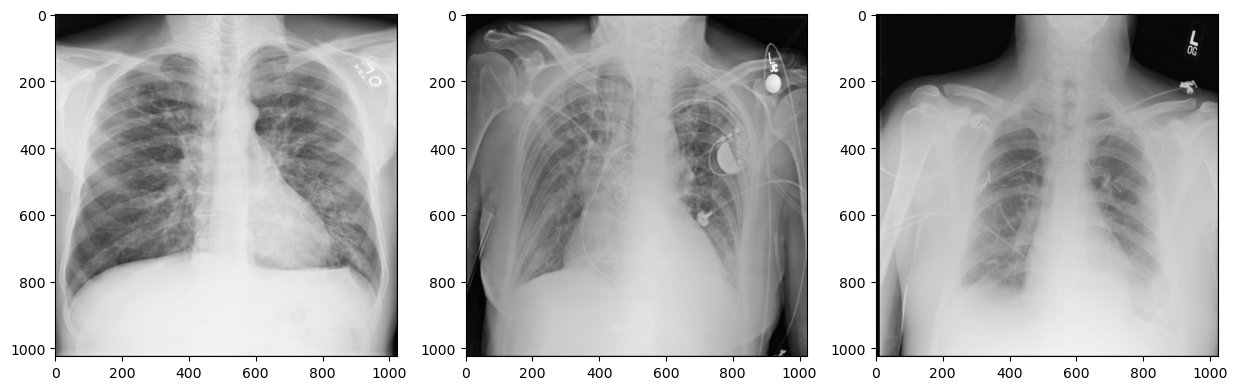

In [208]:
data= nih_val.load_data(0)
image = data['image']
label = data['label']
print(image.shape, label) # 0 : normal, 1: TB, 2: Latent TB
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(image, cmap='gray')

data= nih_val.load_data(20)
image = data['image']
label = data['label']
print(image.shape, label) # 0 : normal, 1: TB, 2: Latent TB
plt.subplot(1,3,2)
plt.imshow(image, cmap='gray')

data= nih_val.load_data(50)
image = data['image']
label = data['label']
print(image.shape, label) # 0 : normal, 1: TB, 2: Latent TB
plt.subplot(1,3,3)
plt.imshow(image, cmap='gray')

In [238]:
import torchxrayvision as xrv

data= nih_val.load_data(125)
image = data['image']
label = data['label']
print(image.shape, label) 

image = cv2.resize(image, (512,512))
image = np.expand_dims(image, axis=2)
print(image.shape, label)

image = xrv.datasets.normalize(image, 255) 
image:np.ndarray = image.mean(2)[None, ...] # Make single color channel
image = image.astype(dtype=np.float32)
print(image.shape, label)
image = torch.from_numpy(image)
print(image.shape, label, image.dtype)

model = xrv.models.ResNet(weights="resnet50-res512-all")
outputs = model(image[None,...]) # or model.features(img[None,...]) 

from pprint import pprint 
pprint(dict(zip(model.pathologies,outputs[0].detach().numpy())))

(1024, 1024, 1) [0]
(512, 512, 1) [0]
(1, 512, 512) [0]
torch.Size([1, 512, 512]) [0] torch.float32
{'Atelectasis': 0.052989762,
 'Cardiomegaly': 0.006757745,
 'Consolidation': 0.006313077,
 'Edema': 0.00033717445,
 'Effusion': 0.02800309,
 'Emphysema': 0.0009935406,
 'Enlarged Cardiomediastinum': 0.5,
 'Fibrosis': 0.0053044436,
 'Fracture': 0.006779639,
 'Hernia': 0.0009738111,
 'Infiltration': 0.07600905,
 'Lung Lesion': 0.5,
 'Lung Opacity': 0.00017274312,
 'Mass': 0.006020151,
 'Nodule': 0.016503315,
 'Pleural_Thickening': 0.006736235,
 'Pneumonia': 0.0014652248,
 'Pneumothorax': 0.0031723196}


In [ ]:
%pip install grad-cam

Lung Opacity
['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
(1, 512, 512)
Shape of image tensor: torch.Size([1, 512, 512])
Number of dimensions: 3


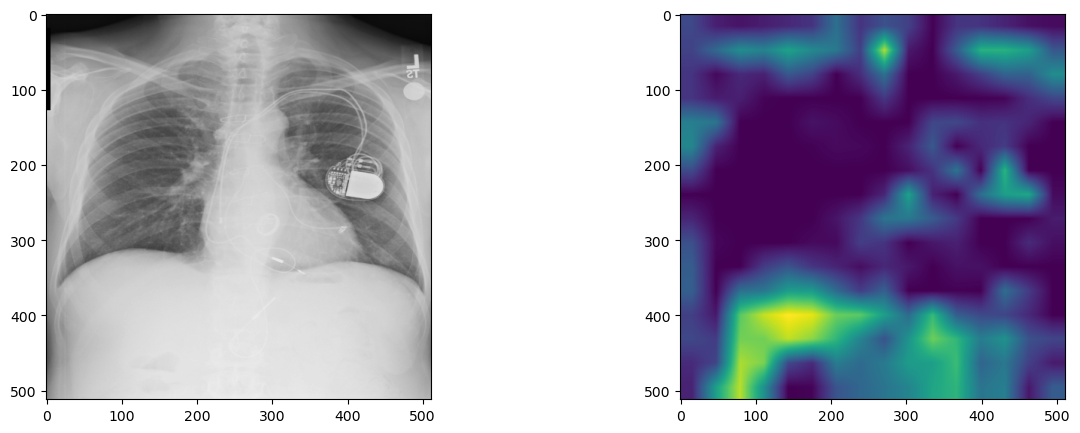

In [239]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

cam = GradCAM(model=model, target_layers=model.model.layer4)

idx = 16
print(model.pathologies[idx])
print(model.pathologies)
actmap = cam(input_tensor=image[None,...], targets=[ClassifierOutputTarget(idx)])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(image[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(actmap[0])
print(actmap.shape)
print("Shape of image tensor:", image.shape)
print("Number of dimensions:", image.ndim)

In [117]:
%pip install pytorch-grad-cam opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


Pneumothorax
Current new_idx: 10
Pathology from new_pathologies: Pneumothorax


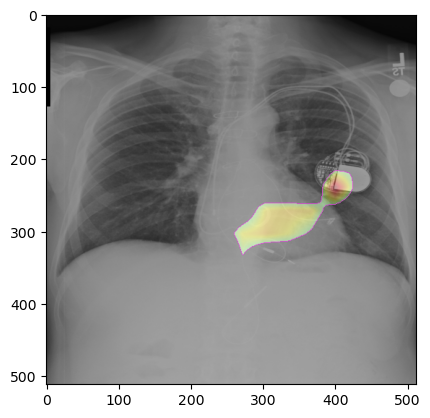

In [212]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import copy

from univdt.components.nih import MAPPER

cam = GradCAM(model=model, target_layers=model.model.layer4)

# 새로운 배열 정의
new_pathologies = {'normal': 0, 'Atelectasis': 3, 'Consolidation': 5, 'Infiltration': 13, 'Pneumothorax': 10, 
                   'Edema': 4, 'Emphysema': 2, 'Fibrosis': 12, 'Effusion': 1, 'Pneumonia': 11, 
                   'Pleural_Thickening': 6, 'Nodule': 9, 'Mass': 8, 'Hernia': 7}

# 새로운 인덱스 생성
new_idx_mapping = {}
for pathology, idx in new_pathologies.items():
    if pathology in MAPPER:
        new_idx_mapping[pathology] = MAPPER[pathology]
    else:
        new_idx_mapping[pathology] = idx

def min_max_norm(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

def post_process_cam(prob, actmap: np.ndarray, image: np.ndarray, threshold: float = 0.5, color_contour=(255,0,255)) -> np.ndarray:
    if prob < threshold:
        draw = copy.deepcopy(image)
        mask = np.zeros_like(image)
        return draw, mask
    actmap = min_max_norm(actmap)
    new_cam = copy.deepcopy(actmap)

    # 가우시안 블러 적용
    new_cam = cv2.GaussianBlur(new_cam, (5, 5), 0)

    # for calc contours
    new_cam2 = np.where(new_cam > threshold, 1, 0).astype(np.uint8)
    contours, _ = cv2.findContours(new_cam2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    new_cam = np.where(new_cam > threshold, new_cam, 0)

    filtered_contours = []
    for contour in contours:
        # 컨투어 내부의 최대 값 찾기
        max_value = np.max(new_cam * (cv2.drawContours(np.zeros_like(new_cam), [contour], 0, 1, thickness=cv2.FILLED)))
        # 최대 값이 0.8 이상인 경우만 남기기
        if max_value >= 0.8:
            filtered_contours.append(contour)
    # 원본에 컨투어 그리기
    if image.shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    draw = cv2.drawContours(copy.deepcopy(image), filtered_contours, -1, color_contour, 1)
    mask = np.zeros_like(image)
    
    # 컨투어 내부를 히트맵으로 채우기
    heatmap = cv2.applyColorMap((new_cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
    mask = cv2.drawContours(mask, filtered_contours, -1, (255, 255, 255), -1)
    mask = cv2.bitwise_and(heatmap, mask)

    return draw, mask

# 이미지에 대한 연산을 수행하고 결과를 출력하는 함수
def process_and_show_result(new_idx):
    print("Current new_idx:", new_idx)
    pathology = list(new_pathologies.keys())[list(new_pathologies.values()).index(new_idx)] # 수정된 부분
    print("Pathology from new_pathologies:", pathology)
    actmap = cam(input_tensor=image[None,...], targets=[ClassifierOutputTarget(new_idx)])
    tt = min_max_norm(image[0].numpy()) * 255.0
    tt = cv2.cvtColor(tt.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    draw, mask = post_process_cam(0.5, actmap[0], tt, 0.5)
    mask = cv2.resize(mask, (draw.shape[1], draw.shape[0]))
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask_rgb = ((mask_rgb - mask_rgb.min()) * (255 / (mask_rgb.max() - mask_rgb.min()))).astype('uint8')
    draw = draw.astype('uint8')
    combined_image = cv2.addWeighted(draw, 0.7, mask_rgb, 0.3, 0)
    plt.imshow(combined_image)
    plt.show()

# new_idx를 변경하면서 결과를 출력
new_idx = 10
pathology = list(new_pathologies.keys())[list(new_pathologies.values()).index(new_idx)] # 수정된 부분
print(pathology)
process_and_show_result(new_idx)


In [165]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import copy

from univdt.components.nih import MAPPER

cam = GradCAM(model=model, target_layers=model.model.layer4)

# 새로운 배열 정의
new_pathologies = {'normal': 0, 'Atelectasis': 3, 'Consolidation': 5, 'Infiltration': 13, 'Pneumothorax': 10, 
                   'Edema': 4, 'Emphysema': 2, 'Fibrosis': 12, 'Effusion': 1, 'Pneumonia': 11, 
                   'Pleural_Thickening': 6, 'Nodule': 9, 'Mass': 8, 'Hernia': 7}

# 새로운 인덱스 생성
new_idx_mapping = {}
for pathology, idx in new_pathologies.items():
    if pathology in MAPPER:
        new_idx_mapping[pathology] = MAPPER[pathology]
    else:
        new_idx_mapping[pathology] = idx

idx = 17
print(model.pathologies[idx])
actmap = cam(input_tensor=image[None,...], targets=[ClassifierOutputTarget(idx)])

def min_max_norm(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

def post_process_cam(prob, actmap: np.ndarray, image: np.ndarray, threshold: float = 0.5, color_contour=(255,0,255)) -> np.ndarray:
    if prob < threshold:
        draw = copy.deepcopy(image)
        mask = np.zeros_like(image)
        return draw, mask
    actmap = min_max_norm(actmap)
    new_cam = copy.deepcopy(actmap)

    # for calc contours
    new_cam2 = np.where(new_cam > threshold, 1, 0).astype(np.uint8)
    contours, _ = cv2.findContours(new_cam2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    new_cam = np.where(new_cam > threshold, new_cam, 0)

    filtered_contours = []
    for contour in contours:
        # 컨투어 내부의 최대 값 찾기
        max_value = np.max(new_cam * (cv2.drawContours(np.zeros_like(new_cam), [contour], 0, 1, thickness=cv2.FILLED)))
        # 최대 값이 0.8 이상인 경우만 남기기
        if max_value >= 0.8:
            filtered_contours.append(contour)
    # 원본에 컨투어 그리기
    if image.shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    draw = cv2.drawContours(copy.deepcopy(image), filtered_contours, -1, color_contour, 1)
    mask = np.zeros_like(image)
    
    # 컨투어 내부를 히트맵으로 채우기
    heatmap = cv2.applyColorMap((new_cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
    mask = cv2.drawContours(mask, filtered_contours, -1, (255, 255, 255), -1)
    mask = cv2.bitwise_and(heatmap, mask)

    return draw, mask

tt = min_max_norm(image[0].numpy())*255.0
tt = cv2.cvtColor(tt.astype(np.uint8), cv2.COLOR_GRAY2BGR)
draw, mask = post_process_cam(0.5, actmap[0], tt, 0.5)

# mask 이미지를 draw 이미지와 동일한 크기로 리사이즈
mask = cv2.resize(mask, (draw.shape[1], draw.shape[0]))

# mask를 BGR 이미지로 변환
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# mask 이미지의 값을 0~255 범위로 정규화
mask_rgb = ((mask_rgb - mask_rgb.min()) * (255 / (mask_rgb.max() - mask_rgb.min()))).astype('uint8')

# draw 이미지의 데이터 타입을 uint8로 변환
draw = draw.astype('uint8')

# mask와 draw 이미지 합치기
combined_image = cv2.addWeighted(draw, 0.7, mask_rgb, 0.3, 0)

plt.imshow(mask_rgb)
plt.subplot(1,1,1)
plt.imshow(combined_image)


KeyError: 13

In [9]:
def min_max_norm(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image
def post_process_cam(prob, actmap: np.ndarray, image: np.ndarray, threshold: 0.5, color_contour=(255,0,255)) -> np.ndarray:
    if prob < threshold:
        draw = copy.deepcopy(image)
        mask = np.zeros_like(image)
        return draw, mask
    actmap = min_max_norm(actmap)
    new_cam = copy.deepcopy(actmap)

    # for calc contours
    new_cam2 = np.where(new_cam > threshold, 1, 0).astype(np.uint8)
    contours, _ = cv2.findContours(new_cam2, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    new_cam = np.where(new_cam > threshold, new_cam, 0)

    filtered_contours = []
    for contour in contours:
        # 컨투어 내부의 최대 값 찾기
        max_value = np.max(new_cam * (cv2.drawContours(np.zeros_like(new_cam),
                                                       [contour], 0, 1,
                                                       thickness=cv2.FILLED)))
        # 최대 값이 0.8 이상인 경우만 남기기
        if max_value >= 0.8:
            filtered_contours.append(contour)
    # 원본에 컨투어 그리기
    if image.shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    draw = cv2.drawContours(copy.deepcopy(image),
                            filtered_contours, -1, color_contour, 1)
    mask = cv2.drawContours(np.zeros_like(image),
                            filtered_contours, -1, 1, -1)
    mask = cv2.cvtColor(actmap, cv2.COLOR_GRAY2RGB) * mask
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    return draw, mask


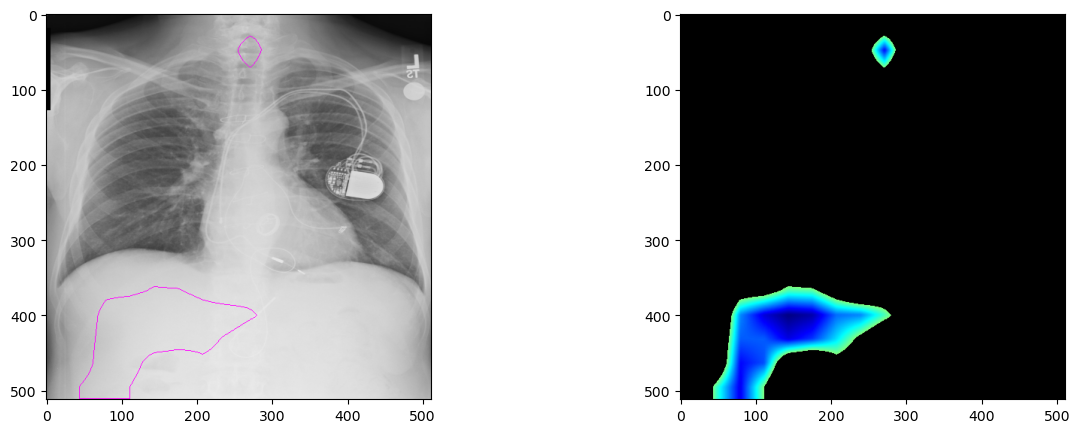

In [213]:
tt = min_max_norm(image[0].numpy())*255.0
# print(tt.min(), tt.max())
tt = cv2.cvtColor(tt.astype(np.uint8), cv2.COLOR_GRAY2BGR)
draw, mask = post_process_cam(0.5, actmap[0], tt, 0.5)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(draw)
plt.subplot(1,2,2)
plt.imshow(mask)

Infiltration


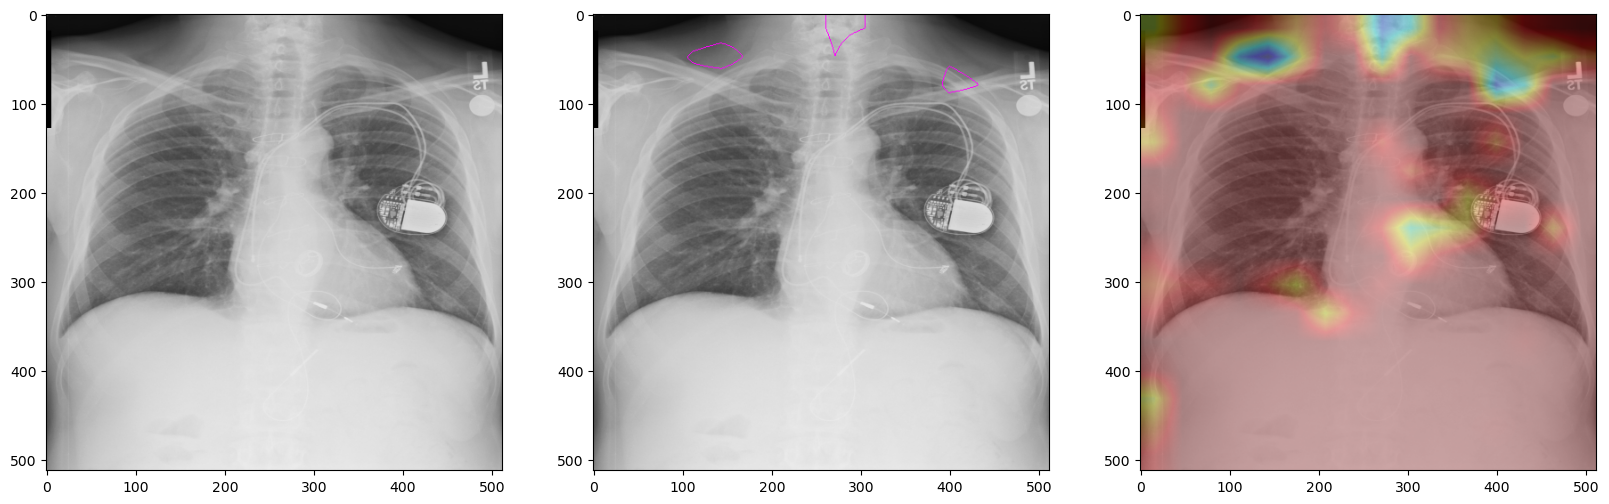

In [139]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import numpy as np
import copy
import matplotlib.pyplot as plt

cam = GradCAM(model=model, target_layers=model.model.layer4)

idx = 2
print(model.pathologies[idx])
actmap = cam(input_tensor=image[None,...], targets=[ClassifierOutputTarget(idx)])

def min_max_norm(image: np.ndarray) -> np.ndarray:
    image = image.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return image

def post_process_cam(prob, actmap: np.ndarray, image: np.ndarray, threshold: 0.5, color_contour=(255,0,255)) -> np.ndarray:
    actmap = min_max_norm(actmap)
    new_cam = copy.deepcopy(actmap)

    # Threshold 이상의 값을 가지는 영역 선택
    mask = np.zeros_like(new_cam)
    mask[new_cam >= threshold] = 1

    # 히트맵 생성
    heatmap = cv2.applyColorMap((new_cam * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # 강조 영역 추출
    contours, _ = cv2.findContours((mask * 255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 원본 이미지에 강조 영역 표시
    draw = cv2.drawContours(copy.deepcopy(image), contours, -1, color_contour, 1)

    return draw, heatmap

# 임계값 이상의 값을 가지는 픽셀에 대해서만 히트맵을 적용하고 강조 영역을 표시합니다.
tt = min_max_norm(image[0].numpy()) * 255.0
tt = cv2.cvtColor(tt.astype(np.uint8), cv2.COLOR_GRAY2BGR)
draw, heatmap = post_process_cam(0.6, actmap[0], tt, 0.6)

# 임계값 이상의 값을 가지는 픽셀에 대해서만 히트맵을 적용한 결과를 원본 이미지에 추가합니다.
combined_with_original = cv2.addWeighted(tt, 0.7, heatmap, 0.3, 0)

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.imshow(tt)
plt.subplot(1, 3, 2)
plt.imshow(draw)
plt.subplot(1, 3, 3)
plt.imshow(combined_with_original)
plt.show()

